# Automatic Prestack Well Tie

#### Import packages

In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
import yaml

from wtie import grid, autotie, viz
from wtie.utils.datasets import tutorial

from pprint import pprint

import matplotlib.pyplot as plt

# uncomment if your browser supports it
#%matplotlib notebook 

### Import data

In this tutorial we work on data from the Well 159-19A of the open [Volve dataset](https://www.equinor.com/en/what-we-do/digitalisation-in-our-dna/volve-field-data-village-download.html). Data is saved in the folder **data/tutorial**.

In [2]:
# data path
folder = Path('../data/tutorial')
assert folder.exists()

inputs = tutorial.load_volve_data(folder, prestack=True)

# choose angle range
tmp_gather = grid.BasePrestackTrace.partial_stacking(inputs.seismic, n=1) # "super traces"
inputs.seismic = grid.BasePrestackTrace.decimate_angles(tmp_gather, 2, 36, 2) # decimate

### Load pretrained network to extract the wavelet

In [3]:
# neural network's weights
model_state_dict = folder / 'trained_net_state_dict.pt'
assert model_state_dict.is_file()

# network training paramters
with open(folder / 'network_parameters.yaml', 'r') as yaml_file:
    training_parameters = yaml.load(yaml_file, Loader=yaml.Loader)
    
wavelet_extractor = tutorial.load_wavelet_extractor(training_parameters, model_state_dict)

Loading network parameters from ../data/tutorial/trained_net_state_dict.pt


/home/valentin/anaconda3/envs/wtie/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning:

CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729006826/work/c10/cuda/CUDAFunctions.cpp:100.)



### Load synthetic modeling tool

In [4]:
modeler = tutorial.get_modeling_tool()

### Parameters for the search and Optimization

In [5]:
print(autotie.tie_v1.__doc__)


    Utility to perform automatic (prestack) seismic to well tie. This version 1
    serves as a base recipe. Feel free to implement your own recipe using the
    various tools of the package.

    Parameters
    ----------
    inputs : _tie.InputSet
        Necessary inputs for the well tie.
    wavelet_extractor : wtie.learning.model.BaseEvaluator
        Object to extract a wavelet using the provided neural network.
    modeler : wtie.modeling.modeling.ModelingCallable
        Synthetic modeling tool.
    wavelet_scaling_params : dict
        Parameters for the search of the optimal absolute wavelet sacle.
        3 parameters: 'wavelet_min_scale' and 'wavelet_max_scale' are the search
        bounds. 'num_iters' (optional) is the total number of iterations for the
        search.
    search_space : dict, optional
        Bounds of the search space. See `get_default_search_space_v1`.
    search_params : dict, optional
        Dict with 3 parameters for the Bayesian search. 'num_iter

In [6]:

# Logs processing
median_length_choice = dict(name="logs_median_size", type="choice",
                  values=[i for i in range(11,63,2)], value_type="int")

median_th_choice = dict(name="logs_median_threshold", type="range",
                  bounds=[0.1, 6.5], value_type="float")

std_choice = dict(name="logs_std", type="range",
                  bounds=[0.5, 5.5], value_type="float")


# bulk shift
table_t_shift_choice = dict(name="table_t_shift", type="range",
                  bounds=[-0.012, 0.012], value_type="float")


search_space = [median_length_choice,
                median_th_choice,
                std_choice,
                table_t_shift_choice
                ]

In [7]:
search_params = dict(num_iters=75, similarity_std=0.02, random_ratio=0.7) #70

Note: the prestack search takes about 10/15 minutes on a laptop and should be faster if you have a GPU.

In [8]:
import warnings
warnings.filterwarnings('ignore')

wavelet_scaling_params = dict(wavelet_min_scale=0.01, wavelet_max_scale=1.0, num_iters=35) #30


outputs = autotie.tie_v1(inputs,
                         wavelet_extractor,
                         modeler,
                         wavelet_scaling_params,
                         search_params=search_params,
                         search_space=search_space,
                         stretch_and_squeeze_params=None) 

Search for optimal parameters


100%|██████████| 75/75 [19:09<00:00, 15.33s/it]


Find wavelet absolute scale


100%|██████████| 18/18 [05:00<00:00, 16.70s/it]


### QC the search

In [9]:
best_parameters, values = outputs.ax_client.get_best_parameters()
means, covariances = values
print(means)
print(covariances)

{'goodness_of_match': 0.728690727066091}
{'goodness_of_match': {'goodness_of_match': 7.0513845e-05}}


In [10]:
pprint(best_parameters)

{'logs_median_size': 15,
 'logs_median_threshold': 3.9502498626708986,
 'logs_std': 2.627271145582199,
 'table_t_shift': 0.008506041526794433}


(<Figure size 432x216 with 1 Axes>,
 <AxesSubplot:title={'center':'Optimization objective'}, xlabel='Iteration #', ylabel='Central correlation'>)

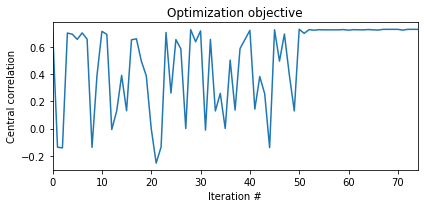

In [11]:
outputs.plot_optimization_objective()

### Visualize results

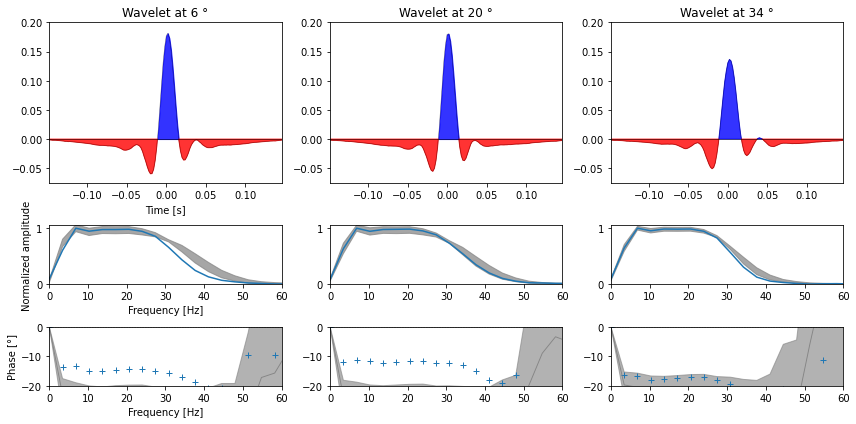

In [12]:
#near, mid, far
fig, axes = outputs.plot_wavelet(three_angles=[6,20,34], fmax=60, phi_max=55, figsize=(12,6))
for ax in axes[:3]:
    ax.set_ylim((-.075, .20))
for ax in axes[6:]:
    ax.set_ylim(-20,0)

[ 2  4  6  8 10 12 14 16 18 20 22 24 26 28 30 32 34 36]


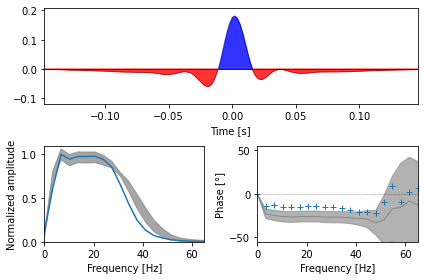

In [13]:
# look at one wavelet
print(outputs.wavelet.angles)
angle_ = 6 # in degrees
viz.plot_wavelet(outputs.wavelet[angle_], fmax=65, phi_max=55, figsize=None);

Text(0.5, 0.98, '')

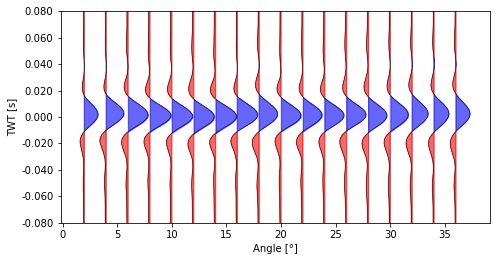

In [14]:
fig,ax = viz.plot_prestack_wiggle_trace(outputs.wavelet, figsize=(7,4))
ax.set_ylim((-0.08,0.08))
fig.suptitle("")

In [15]:
outputs.seismic.angles

array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
       36])

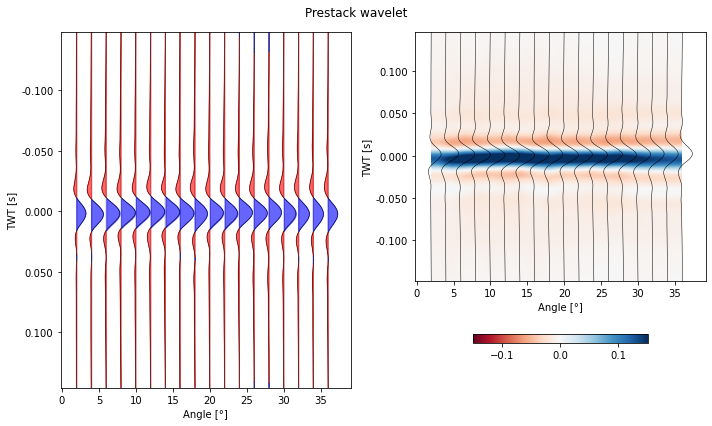

In [16]:
# all wavelets
fig, axes = plt.subplots(1,2, figsize=(10,6))
viz.plot_prestack_wiggle_trace(outputs.wavelet, fig_axes=(fig,axes[0]))
viz.plot_prestack_trace_as_pixels(outputs.wavelet, fig_axes=(fig,axes[1]),
                                  im_params=dict(cmap='RdBu', vmin=-0.15, vmax=0.15))

fig.tight_layout()

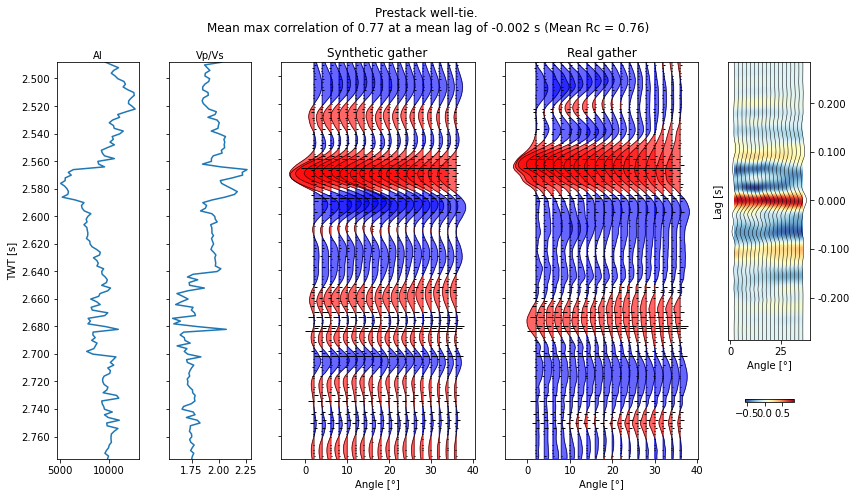

In [17]:
wigg_scale_ = 150
fig, axes = outputs.plot_tie_window(wiggle_scale=wigg_scale_, figsize=(12,7),
                                   decimate_wiggles=1, reflectivity_scale=15)

Text(0.5, 1.0, 'Synthetic gather')

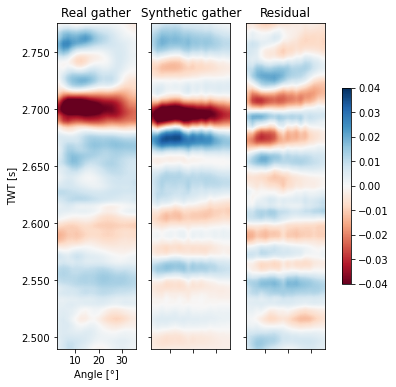

In [18]:
fig, axes, cbar = viz.plot_prestack_residual_as_pixels(outputs.seismic, outputs.synth_seismic,
                                                   im_params=dict(cmap='RdBu', vmin=-4e-2,vmax=4e-2))
axes[0].set_title("Real gather")
axes[1].set_title("Synthetic gather")

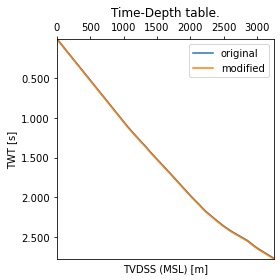

In [19]:
fig,ax = viz.plot_td_table(inputs.table, plot_params=dict(label='original'))
viz.plot_td_table(outputs.table,  plot_params=dict(label='modified'), fig_axes=(fig,ax))
ax.legend(loc='best')

### Automatic Stretch & Squeeze

In [20]:
s_and_s_params = dict(window_length=0.040, max_lag=0.008, reference_angle=14)

outputs2 = autotie.stretch_and_squeeze(inputs,
                                       outputs,
                                       wavelet_extractor,
                                       modeler,
                                       wavelet_scaling_params,
                                       best_parameters,
                                       s_and_s_params)

Find wavelet absolute scale


100%|██████████| 18/18 [03:48<00:00, 12.71s/it]


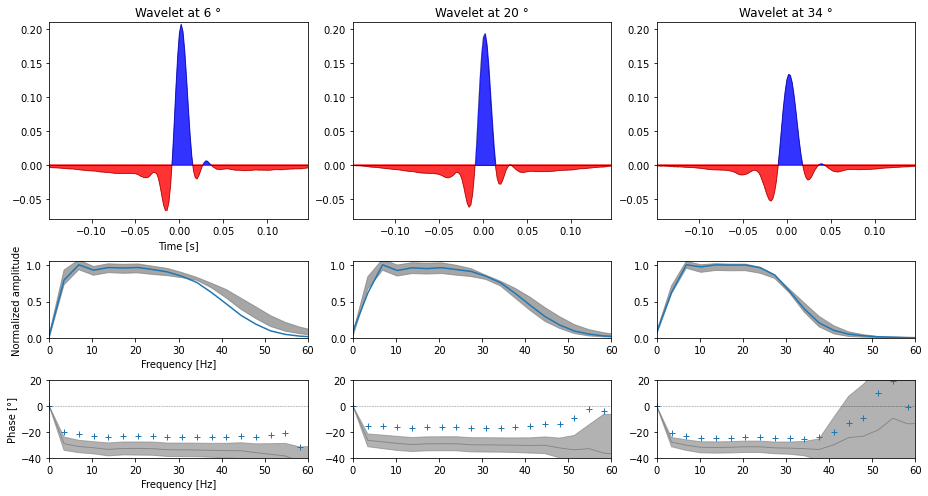

In [21]:
fig, axes = outputs2.plot_wavelet(three_angles=[6,20,34], fmax=60, phi_max=55, figsize=(13,7))
for ax in axes[:3]:
    ax.set_ylim((-.08, .21))
for ax in axes[6:]:
    ax.set_ylim(-40,20)

Text(0.5, 0.98, '')

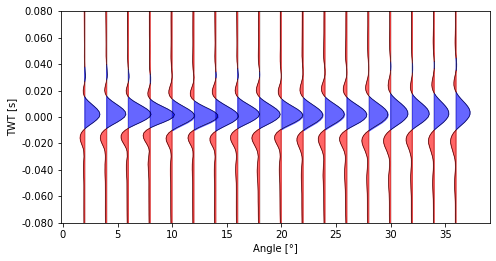

In [22]:
fig,ax = viz.plot_prestack_wiggle_trace(outputs2.wavelet, figsize=(7,4))
ax.set_ylim((-0.08,0.08))
fig.suptitle("")

Text(0.5, 1.0, 'Cross-correlation')

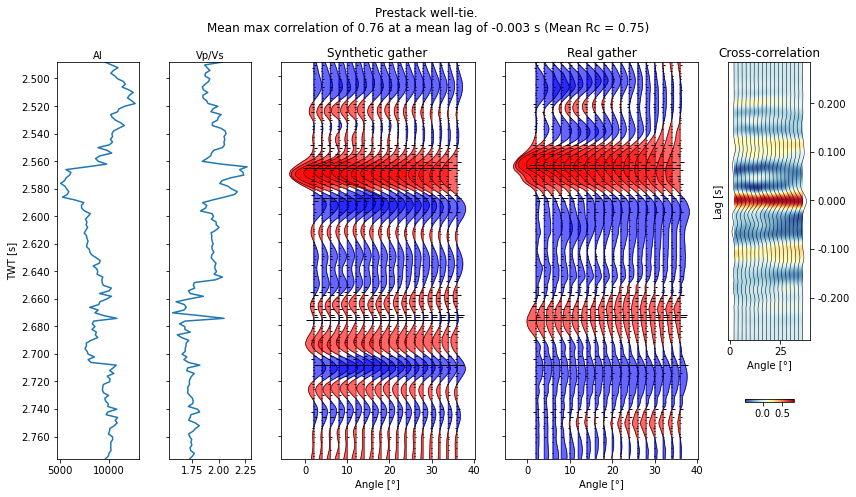

In [23]:
fig, axes = outputs2.plot_tie_window(wiggle_scale=wigg_scale_, figsize=(12,7),
                                   decimate_wiggles=1, reflectivity_scale=15)
axes[-1].set_title("Cross-correlation")

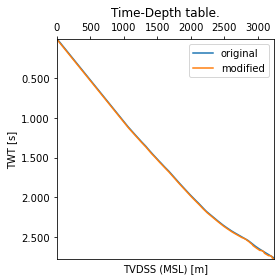

In [24]:
fig,ax = viz.plot_td_table(inputs.table, plot_params=dict(label='original'))
viz.plot_td_table(outputs2.table,  plot_params=dict(label='modified'), fig_axes=(fig,ax))
ax.legend(loc='best')